In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import numpy as np

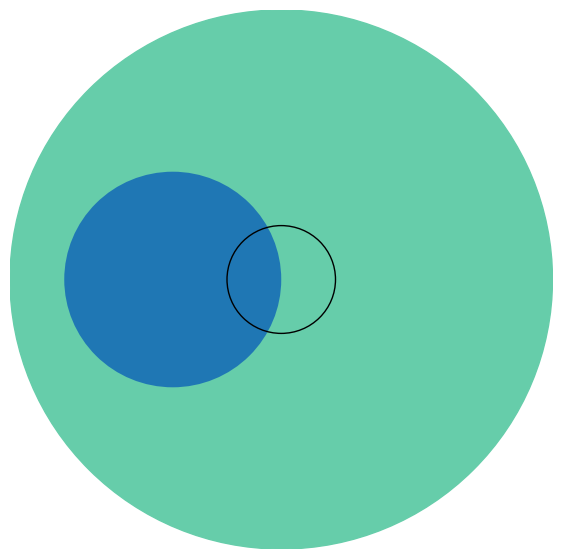

In [2]:
circle1 = plt.Circle((0.5, 0.5), 0.5, color='mediumaquamarine')
circle2 = plt.Circle((0.3, 0.5), 0.2)
circle3 = plt.Circle((0.5, 0.5), 0.1, fill=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
fig.set_size_inches(7, 7)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

plt.axis('off')
plt.show()

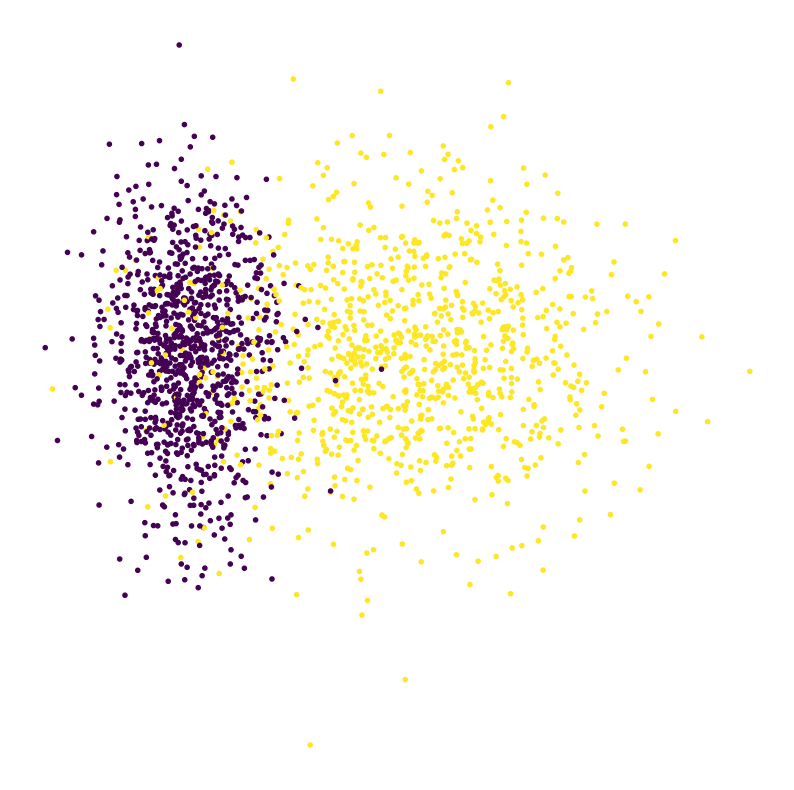

In [3]:
x, y = make_classification(n_samples=2000,
                          n_features=2,
                          n_informative=1,
                          n_redundant=0,
                          n_clusters_per_class=1)

fig, ax = plt.subplots() 
fig.set_size_inches(10, 10)
plt.scatter(x[:,0], x[:,1], marker='.', c=y)
plt.axis('off')
plt.show()

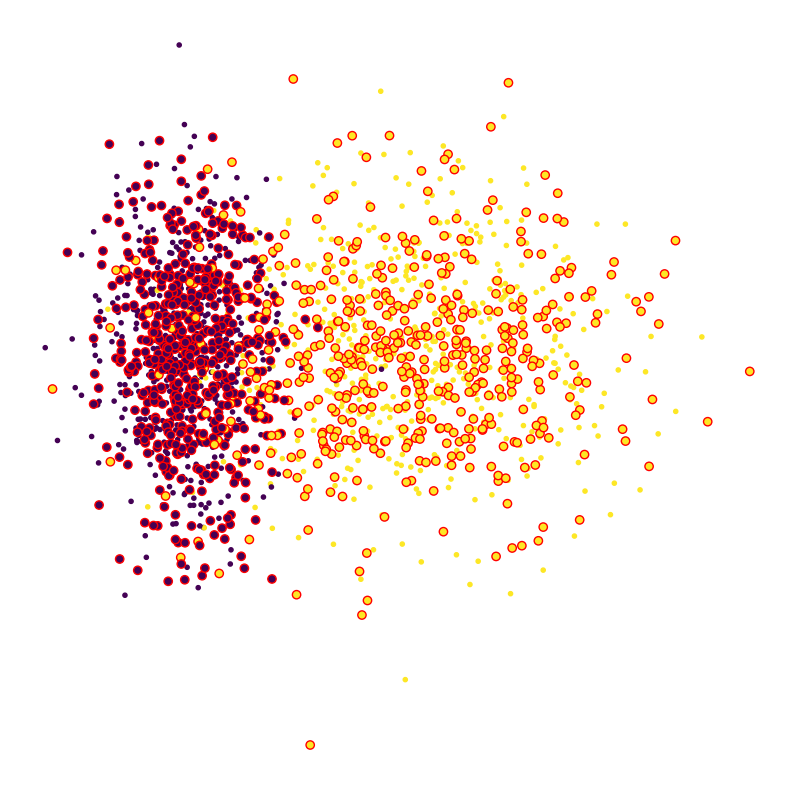

In [4]:
x_in, x_out, y_in, y_out = train_test_split(x, y, train_size=0.5, shuffle=False)
fig, ax = plt.subplots() 
fig.set_size_inches(10, 10)
plt.scatter(x_out[:,0], x_out[:,1], marker='.', c=y_out)
plt.scatter(x_in[:,0], x_in[:,1], marker='o', c=y_in, edgecolor='r')
plt.axis('off')
plt.show()

In [5]:
clf = MLPClassifier(max_iter=500)
clf.fit(x_in, y_in)

MLPClassifier(max_iter=500)

In [6]:
y_pred = clf.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1001
           1       0.96      0.89      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



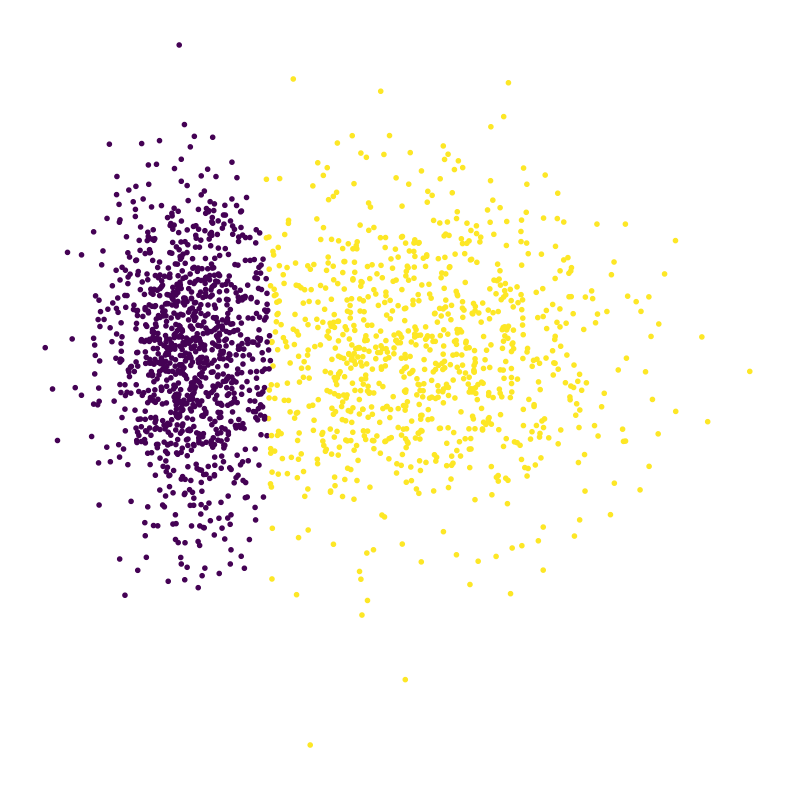

In [7]:
fig, ax = plt.subplots() 
fig.set_size_inches(10, 10)
plt.scatter(x[:,0], x[:,1], marker='.', c=y_pred)
plt.axis('off')
plt.show()

In [8]:
def get_attack_data(model, n_classes, train_data, test_data):
    # Get prediction probabilities from sklearn model
    probabilities = np.vstack(
        (
            model.predict_proba(train_data),
            model.predict_proba(test_data)
        )
    )

    probabilities = np.sort(probabilities, axis=1)
    probabilities = np.flip(probabilities, axis=1)
    n_probs = 3 if n_classes > 2 else 2
    probabilities = probabilities[:, :n_probs]

    # Membership labels
    membership = np.vstack(
        (
            np.ones((train_data.shape[0], 1), np.uint8),
            np.zeros((test_data.shape[0], 1), np.uint8)
        )
    ).flatten()

    return probabilities, membership


def train_attack_model(probabilities, labels):
    mlp_clf = MLPClassifier(max_iter=500)

    param_grid = {
        'hidden_layer_sizes': [(64,), (32, 32), (32, 32, 32)],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],
    }
    n_jobs = -1

    attack_model = GridSearchCV(mlp_clf, param_grid=param_grid, cv=3, n_jobs=n_jobs, refit=True, verbose=0)
    attack_model.fit(probabilities, labels)

    return attack_model.best_estimator_

[1 1 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.49      0.17      0.25      1000
           1       0.50      0.83      0.62      1000

    accuracy                           0.50      2000
   macro avg       0.49      0.50      0.43      2000
weighted avg       0.49      0.50      0.43      2000



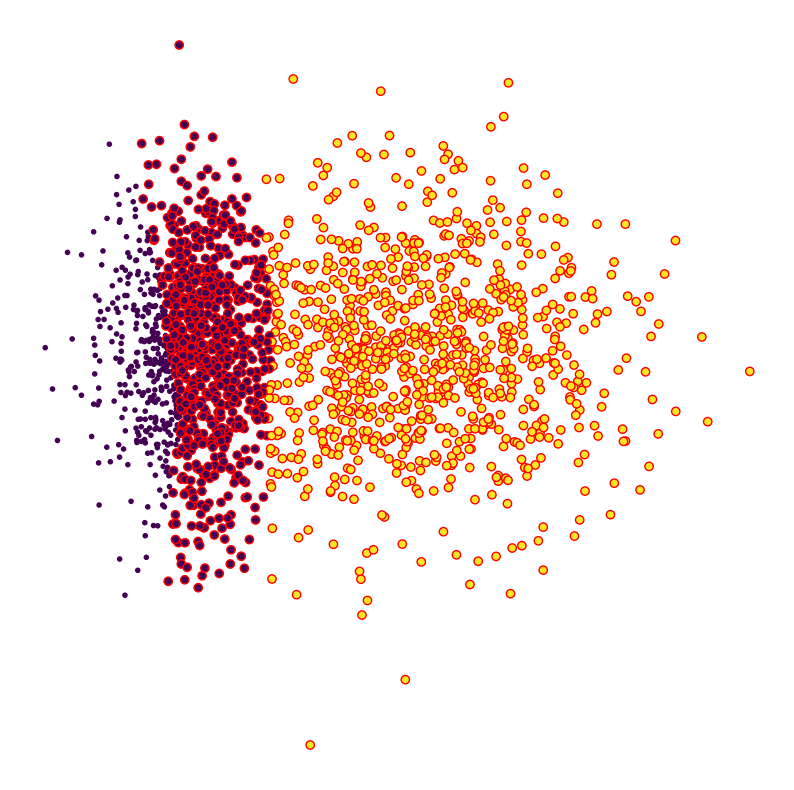

In [9]:
confidence, membership = get_attack_data(clf, 2, x_in, x_out)
attack_model = train_attack_model(confidence, membership)

membership_prediction = attack_model.predict(clf.predict_proba(x))
print(membership_prediction)
print(classification_report(membership, membership_prediction))

fig, ax = plt.subplots() 
fig.set_size_inches(10, 10)
nonmembers = x[membership_prediction==0]
nonmembers_y = y_pred[membership_prediction==0]
members = x[membership_prediction==1]
members_y = y_pred[membership_prediction==1]
plt.scatter(nonmembers[:,0], nonmembers[:,1], marker='.', c=nonmembers_y)
plt.scatter(members[:,0], members[:,1], marker='o', c=members_y, edgecolor='r')
plt.axis('off')
plt.show()

In [10]:
import tensorflow as tf

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()